In [12]:
import lifesim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib
from matplotlib.lines import Line2D
from scipy.ndimage import gaussian_filter
import matplotlib.colors
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from lifesim.util.habitable import single_habitable_zone

### Import the catalog in Lay configuration with paper I occurrence statistics

In [49]:
path = {'lay': {'config': '/home/ipa/quanz/user_accounts/fdannert/noise_paper_23/70_results/S01_Lay/S01_base_bryson_hab2high.yaml',
            'catalog': '/home/ipa/quanz/user_accounts/fdannert/noise_paper_23/70_results/S01_Lay/S01_base_bryson_hab2high_catalog.hdf5'},
        'et' : {'config': '/home/ipa/quanz/user_accounts/fdannert/noise_paper_23/70_results/S02_earth_twin/S02_earth_twin_bryson_high_July23.yaml',
               'catalog': '/home/ipa/quanz/user_accounts/fdannert/noise_paper_23/70_results/S02_earth_twin/S02_earth_twin_bryson_high_July23_catalog.hdf5'}
       }

use = 'et'

In [16]:
bus_0 = lifesim.Bus()
bus_0.build_from_config(filename=path['lay']['config'])

bus_0.data.import_catalog(input_path=path['lay']['catalog'],
                        noise_catalog=True)

ana = lifesim.SampleAnalysisModule(name='ana')
bus_0.add_module(ana)

ana.get_fundamental_snr()

opt_0 = lifesim.Optimizer(name='opt_0')
bus_0.add_module(opt_0)
ahgs_0 = lifesim.AhgsModule(name='ahgs_0')
bus_0.add_module(ahgs_0)

bus_0.connect(('opt_0', 'ahgs_0'))
opt_0.ahgs()

Importing Catalog...
Beginning Import...
Import completed (Time: 0.13582730293273926), changing string object types...
[Done] (Time: 0.017614126205444336)
Importing Noise Catalog...
[Done]
Number of planets detected by stellar type:
A: 0.0  F: 5.196  G: 4.938  K: 10.226  M: 0.0  -  (2.0 / 2.0) yrs observed


In [74]:
bus_1 = lifesim.Bus()
bus_1.build_from_config(filename=path[use]['config'])

bus_1.data.import_catalog(input_path=path[use]['catalog'],
                        noise_catalog=True)

bus_1.data.options.set_manual(instrumental_opt=True,
                             limit={'A': 0.,
                                   'F': np.inf,
                                   'G': np.inf,
                                   'K': np.inf,
                                 'M': 0.}
                             )

bus_1.data.catalog_remove_distance(stype='A', mode='larger', dist=0.)
bus_1.data.catalog_remove_distance(stype='M', mode='larger', dist=0.)

opt_1 = lifesim.Optimizer(name='opt_1')
bus_1.add_module(opt_1)
ahgs_1 = lifesim.AhgsModule(name='ahgs_1')
bus_1.add_module(ahgs_1)

bus_1.connect(('opt_1', 'ahgs_1'))
opt_1.ahgs()

Importing Catalog...
Beginning Import...
Import completed (Time: 0.4426236152648926), changing string object types...
[Done] (Time: 0.06590127944946289)
Importing Noise Catalog...
[Done]
Number of planets detected by stellar type:
A: 0.0  F: 4.2269076305220885  G: 4.644578313253012  K: 8.391566265060241  M: 0.0  -  (2.0 / 2.0) yrs observedddd


In [75]:

(4.2269076305220885 + 4.644578313253012 + 8.391566265060241)/(5.196 + 4.938 + 10.226)

0.8478905800017358

## Completeness plot

/tmp/ipykernel_2429892/272602639.py:26: RuntimeWarning: invalid value encountered in divide
  z = np.nan_to_num(hist_mask/hist_base, posinf=0.).T


IndexError: list index out of range

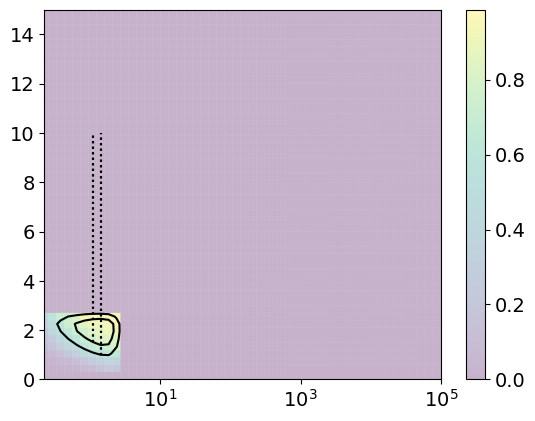

In [45]:
catalog = bus_0.data.catalog
mask = catalog.detected
mask_base = catalog.int_time > 0

catalog['insol_p'] = catalog.l_sun/catalog.semimajor_p**2

xlim = [np.min(catalog.insol_p)*1, 100000]
ylim = [0, 15]
nbins = 51

hist_base, binx, biny = np.histogram2d(x=catalog.insol_p[mask_base],
                     y=catalog.radius_p[mask_base],
                     bins=(np.logspace(np.log10(xlim[0]),np.log10(xlim[1]), nbins),
                           np.linspace(ylim[0], ylim[1], nbins)))

hist_mask, binx, biny = np.histogram2d(x=catalog[mask].insol_p,
                     y=catalog[mask].radius_p,
                     bins=(np.logspace(np.log10(xlim[0]),np.log10(xlim[1]), nbins), 
                          np.linspace(ylim[0], ylim[1], nbins)))

#plt.imshow((hist_mask/hist_base).T, 
#           origin='lower', 
#           extent=[biny[0], biny[-1], binx[0], binx[1]]
#          )

z = np.nan_to_num(hist_mask/hist_base, posinf=0.).T

plt.pcolor(binx, biny, z, 
           alpha=0.3,
          edgecolors=None)

plt.xscale('log')
plt.colorbar()

centx = [binx[i] + 0.5*(binx[i+1]-binx[i]) for i in range(len(binx)-1)]
centy = [biny[i] + 0.5*(biny[i+1]-biny[i]) for i in range(len(biny)-1)]

z[18:, :] = np.nan
z[14:, 25:] = np.nan

cont = plt.contour(centx, centy, gaussian_filter(z,
sigma=(1, 1)), levels=[0.5, 0.7, 0.9], colors='k', alpha=1)


for line in cont.collections:
    p = line.get_paths()[0].vertices
    plt.vlines(x=p[0][0], ymin=p[0][1], ymax=10, color='k', ls=':')
    plt.vlines(x=p[-1][0], ymin=p[-1][1], ymax=10, color='k', ls=':')

ax.invert_xaxis()

plt.ylim(0, 10)

plt.show()


In [47]:
def plot_contour_completeness(ax,
                             mask,
                             mask_base,
                             xlim,
                             ylim,
                             nbins,
                              lim_cont_left,
                              lim_cont_right,
                              sigma,
                              catalog,
                              color,
                              levels,
                              clicks=None,
                              contourf=False,
                              label=None
                             ):
    
    catalog['insol_p'] = catalog.l_sun/catalog.semimajor_p**2
    
    hist_base, binx, biny = np.histogram2d(x=catalog.insol_p[mask_base],
                         y=catalog.radius_p[mask_base],
                         bins=(np.logspace(np.log10(xlim[0]),np.log10(xlim[1]), nbins),
                               np.linspace(ylim[0], ylim[1], nbins)))

    hist_mask, binx, biny = np.histogram2d(x=catalog[mask].insol_p,
                         y=catalog[mask].radius_p,
                         bins=(np.logspace(np.log10(xlim[0]),np.log10(xlim[1]), nbins), 
                              np.linspace(ylim[0], ylim[1], nbins)))

    z = np.nan_to_num(hist_mask/hist_base, posinf=0.).T

    centx = [binx[i] + 0.5*(binx[i+1]-binx[i]) for i in range(len(binx)-1)]
    centy = [biny[i] + 0.5*(biny[i+1]-biny[i]) for i in range(len(biny)-1)]

    z[lim_cont_left:, :] = np.nan
    z[lim_cont_right:, 25:] = np.nan
    
    def fmt(x):
        x*=100
        s = f"{x:.1f}"
        if s.endswith("0"):
            s = f"{x:.0f}"
        return rf"{s} \%" if plt.rcParams["text.usetex"] else f"{s} %"
    
    if contourf:
        cont = ax.contourf(centx, centy, gaussian_filter(z,
                                                          sigma=(sigma, sigma)), 
                            levels=levels,
                            linestyles='solid',
                            cmap='binary', 
                            alpha=0.5,
                           label=label)
        ax.contour(centx, centy, gaussian_filter(z,
                                                         sigma=(sigma, sigma)), 
                           levels=levels, 
                           colors=color, 
                           alpha=0.3)
    else:
        
        cont = ax.contour(centx, centy, gaussian_filter(z,
                                                         sigma=(sigma, sigma)), 
                           levels=levels, 
                           cmap=cmap,
                           norm=norm,
                           alpha=1,
                          label=label)
        
        labels= ax.clabel(cont, cont.levels, inline=True, fmt=fmt, fontsize=10,
                  rightside_up=False,
                  manual=clicks)
        
        for l in labels:
            l.set_rotation(0.)
        
    return cont

#    for line in cont.collections:
#        p = line.get_paths()[0].vertices
#        plt.vlines(x=p[0][0], ymin=p[0][1], ymax=ylim[1], color=color, ls=':')
#        plt.vlines(x=p[-1][0], ymin=p[-1][1], ymax=ylim[1], color=color, ls=':')

/tmp/ipykernel_2429892/1113493055.py:30: RuntimeWarning: invalid value encountered in divide
  z = np.nan_to_num(hist_mask/hist_base, posinf=0.).T
/tmp/ipykernel_2429892/1113493055.py:46: UserWarning: The following kwargs were not used by contour: 'label'
  cont = ax.contourf(centx, centy, gaussian_filter(z,
/tmp/ipykernel_2429892/1113493055.py:60: UserWarning: The following kwargs were not used by contour: 'label'
  cont = ax.contour(centx, centy, gaussian_filter(z,


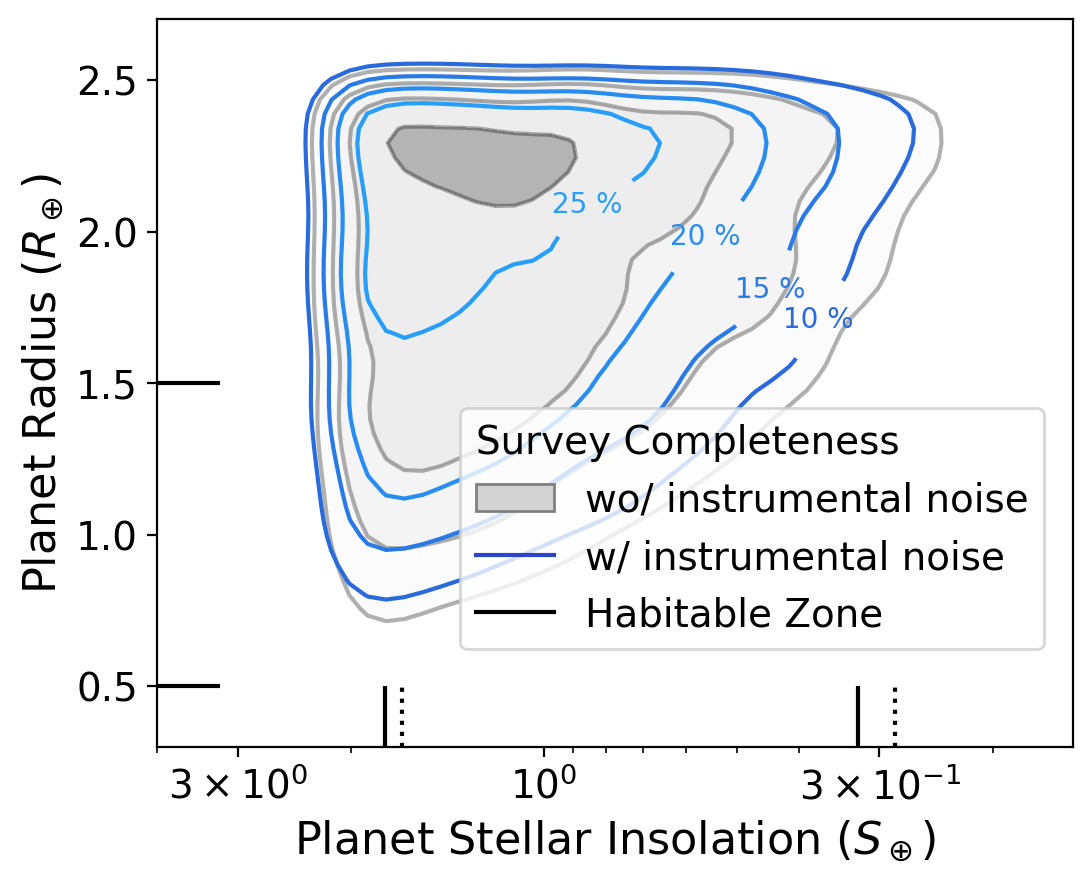

In [73]:
%matplotlib inline

settings = {'lay': {'smooth': [2, 1.5],
                    'clicks': [(7.5e-1, 1.45), (1, 1.7), (1.2, 1.85), (1.5, 2)]
                   },
           'et': {'smooth': [2, 2],
                  'clicks': [(3e-1, 1.7), (4e-1, 1.8), (6e-1, 2), (1, 2.2)]
                   }}

small_size = 14
medium_size = 16
large_size = 18

plt.rc('font', size=small_size)          # controls default text sizes
plt.rc('axes', titlesize=small_size)     # fontsize of the axes title
plt.rc('axes', labelsize=medium_size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=small_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=small_size)    # fontsize of the tick labels
plt.rc('legend', fontsize=small_size)    # legend fontsize
plt.rc('figure', titlesize=medium_size)  # fontsize of the figure title

xlim = [1.5e-1, 4]
ylim = [0.3, 2.7]
nbins = 51
levels=[0.1, 0.15, 0.2, 0.25, 1]
#levels = [0.25, 0.5, 0.75, 0.95, 1]

norm = matplotlib.colors.Normalize(0,0.25)
colors = [[norm(0.), '#2B46C9'],
          [norm(0.25), '#269FFB'],]

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

fig, ax = plt.subplots(figsize=(15*0.393701, 12*0.393701), dpi=200)
cont_base = plot_contour_completeness(ax=ax,
                         mask=np.logical_and(bus_0.data.catalog.detected,
                                            bus_0.data.catalog.stype!='A'),
                         mask_base=np.logical_and(bus_0.data.catalog.int_time >= 0,
                                                 bus_0.data.catalog.stype!='A'),
                         xlim=xlim,
                         ylim=ylim,
                         nbins=51,
                         lim_cont_left=50,
                         lim_cont_right=50,
                         sigma=settings[use]['smooth'][0],
                         catalog=bus_0.data.catalog,
                         color='k',
                         levels=levels,
                         contourf=True,
                         label='Test1')

cont_noise = plot_contour_completeness(ax=ax,
                         mask=np.logical_and(bus_1.data.catalog.detected,
                                            bus_1.data.catalog.stype!='A'),
                         mask_base=np.logical_and(bus_1.data.catalog.int_time >= 0,
                                                 bus_1.data.catalog.stype!='A'),
                         xlim=xlim,
                         ylim=ylim,
                         nbins=51,
                         lim_cont_left=50,
                         lim_cont_right=50,
                         sigma=settings[use]['smooth'][1],
                         catalog=bus_1.data.catalog,
                         color='#6ec3fa',
                         levels=levels,
                         label='test2',
                                      clicks=settings[use]['clicks'])

#xlim = (1e-2, 5e3)

plt.hlines(y=[0.5, 1.5], xmin=xlim[1], xmax=xlim[1]*0.8, color='k')

# G-star
plt.vlines(x=single_habitable_zone(model='MS',
                     temp_s=5778.,
                     radius_s=1.)[:2],
          ymin=ylim[0],
          ymax=ylim[0]+0.2,
          color='k')

# K-star
plt.vlines(x=single_habitable_zone(model='MS',
                     temp_s=4990.,
                     radius_s=0.742)[:2],
          ymin=ylim[0],
          ymax=ylim[0]+0.2,
          color='k',
          ls=':')

plt.ylim(ylim)
plt.xlim(xlim)
plt.xscale('log')
ax.invert_xaxis()

plt.xticks([3.e-1, 1.e0, 3.e0],
               [r'$3 \times 10^{-1}$',
               r'$10^{0}$',
               r'$3 \times 10^{0}$'])

plt.xlabel('Planet Stellar Insolation ($S_\oplus$)')
plt.ylabel('Planet Radius ($R_\oplus$)')

legend_elements = [Patch(facecolor='lightgray', edgecolor='gray',
                         label='wo/ instrumental noise'),
                   Line2D([0], [0], color='#2B46C9', lw=1.5, label='w/ instrumental noise'),
                  Line2D([0], [0], color='k', lw=1.5, label='Habitable Zone'),]

legend = ax.legend(handles=legend_elements, 
                   loc='center', 
                   title='Survey Completeness', 
                   alignment='left',
                  bbox_to_anchor=[0.65, 0.3])

plt.show()

In [ ]:
np.sum(bus)